In [8]:
from __future__ import division, absolute_import

import os
import sys
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import h5py
import pickle
import numpy as np
import keras
import pandas as pd
import random

from glob import glob
from keras.models import load_model
from keras import models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

from src.Target import Target

np.random.seed(1)
random.seed(1)
%matplotlib inline

In [9]:
list_paddings = ['ext_padding', 'mid_padding', 'post_padding', 'pre_padding', 
                 'rnd_padding', 'strf_padding',  "zoom_padding"]

task = 'task1/'
nfolds = 10
folder = 'EC_number/archaea/1conv/64filts_size5/'
nshape = (1, 1000, 26)
nlayer = 2

In [34]:
def search_model (folder, fold, task, padding):
    model_path = "".join((absPath, "data/checkpoint/", folder, task, list_paddings[2], "/", "1", "/"))
    model_file = glob(os.path.join(model_path, "weights-*.hdf5"))[0]
    return model_file

def random_prot_idx(folder, task):
    if task == "task1":
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')
    else:
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_data_enz.pickle')
    with open(file_idcs, "rb") as input_file:
        splitting_sets = pickle.load(input_file)[0]
    i_train, i_val, i_test = splitting_sets
    len_test = len(i_test)
    rnd_index = random.randint(0, len_test-1)
    protein_index = i_test[rnd_index]
    return protein_index

def load_prot(folder, protein_index, padding, labels_label, newshape):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    prot = f1[padding][protein_index]
    label_prot = f1[labels_label][protein_index]
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped, label_prot

def obtain_activations(model_path, n_layer, seq_reshaped):
    model = load_model(model_path)
    layer_output = model.layers[n_layer].output
    activation_model = models.Model(inputs=model.input, outputs=layer_output) 
    activations = activation_model.predict(seq_reshaped, batch_size=1)
    shape_act = activations.shape
    activations_reshaped = np.reshape(activations, newshape=(shape_act[2], shape_act[1]))
    #print(activations_reshaped.shape)
    return activations_reshaped

def activations_to_df(activations, padding, fold):
    activations_df = pd.DataFrame(activations)
    activations_df["padding"] = padding
    activations_df["order"] = list(range(0,activations.shape[0]))
    activations_df["fold"] = fold
    #label_prot_noonehot = np.argmax(label_prot, -1)
    #activations_df["label"] = label_prot_noonehot
    return activations_df

def train_pca(list_dfs, ncomps):
    df_joint = pd.concat(list_dfs, ignore_index=True)
    x = df_joint.drop(['order', 'padding', 'fold', 'label'], axis=1).values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=ncomps)
    principalComponents = pca.fit_transform(x)
    principal_df = pd.DataFrame(principalComponents, columns=["PC1", "PC2"])
    final_df = pd.concat([principal_df, df_joint[['padding']], df_joint[['order']], 
                          df_joint[['fold']], df_joint[['label']]], axis=1)
    return final_df, pca

def plot_pca(df, pca, list_paddings):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    label_x = " ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)"))
    label_y = " ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))
    ax.set_xlabel(label_x, fontsize = 15)
    ax.set_ylabel(label_y, fontsize = 15)
    ax.set_title('PCA of Conv1D (size=5)', fontsize = 20)
    colors = ["#FFED6F","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69",
         "#FCCDE5"]
    for padding, color in zip(list_paddings,colors):
        indicesToKeep = df['padding'] == padding
        print(padding, df.loc[indicesToKeep, 'PC1'].shape)
        ax.scatter(df.loc[indicesToKeep, 'PC1']
               , df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50,
                  alpha=1)
    ax.legend(list_paddings)
    ax.grid()
    
#function to select proteins of the test set with an specific enzimatic label
def find_prot_labeled(folder, enz_label, quant=2):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    indices_enzymes = []
    while len(indices_enzymes)<quant:
        idx = random_prot_idx(folder, "task2")
        label_prot = np.argmax(f1["labels_task2"][idx])
        if label_prot == enz_label:
            indices_enzymes.append(idx)
    return indices_enzymes

def load_prot_labeled(folder, padding, newshape, enz_label, idx):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    prot = f1[padding][idx]
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped

In [11]:
# Defining protein to take
idx = random_prot_idx(folder, "task1")
print(idx)
#Define list of dataframes
lista_dfs = []
for model_type in list_paddings:
    print("Model type: ", model_type)
    for fold in range(nfolds):
        model = search_model(folder, str(fold), task, model_type)
        prot, label = load_prot(folder, idx, model_type, "labels_task1", nshape)
        activations = obtain_activations(model, nlayer, prot)
        act_df = activations_to_df(activations, model_type, fold, label)
        lista_dfs.append(act_df)

15840
Model type:  ext_padding
Model type:  mid_padding
Model type:  post_padding
Model type:  pre_padding
Model type:  rnd_padding
Model type:  strf_padding
Model type:  zoom_padding


ext_padding (640,)
mid_padding (640,)
post_padding (640,)
pre_padding (640,)
rnd_padding (640,)
strf_padding (640,)
zoom_padding (640,)


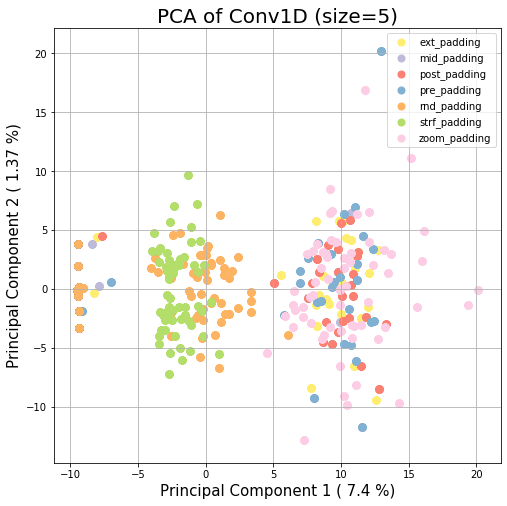

In [12]:
final_df, pca = train_pca(lista_dfs, 2)
plot_pca(final_df, pca, list_paddings)

In [32]:
#de momento lo haré sin la clase 7
prots_pca = []
for enz_label in range(1,7):
    indices_enzymes = find_prot_labeled(folder, enz_label)
    print(indices_enzymes, enz_label)
    for idx,i in enumerate(indices_enzymes):
        for padding in list_paddings:
            seq = load_prot_labeled(folder, padding, nshape, enz_label, i)
            prots_pca.append((seq,enz_label, padding))
            #print(enz_label, "prot", idx)
    

[17638, 3416] 1
[11266, 11893] 2
[16285, 1886] 3
[18074, 16317] 4
[14193, 16115] 5
[11947, 16196] 6


In [ ]:
#Define list of dataframes
task = "task2/"
lista_dfs = []
for tup in prots_pca:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    print("Model type: ", model_type, "enzyme type", enz_type)
    for fold in range(nfolds):
        model = search_model(folder, str(fold), task, model_type)
        activations = obtain_activations(model, nlayer, prot)
        act_df = activations_to_df(activations, model_type, fold)
        act_df["enzyme_type"] = tup[1]
        lista_dfs.append(act_df)

Model type:  ext_padding enzyme type 1
Model type:  mid_padding enzyme type 1
Model type:  post_padding enzyme type 1
Model type:  pre_padding enzyme type 1
Model type:  rnd_padding enzyme type 1
Model type:  strf_padding enzyme type 1
Model type:  zoom_padding enzyme type 1
Model type:  ext_padding enzyme type 1
Model type:  mid_padding enzyme type 1
Model type:  post_padding enzyme type 1
Model type:  pre_padding enzyme type 1
Model type:  rnd_padding enzyme type 1
Model type:  strf_padding enzyme type 1
Model type:  zoom_padding enzyme type 1
Model type:  ext_padding enzyme type 2
Model type:  mid_padding enzyme type 2
Model type:  post_padding enzyme type 2
Model type:  pre_padding enzyme type 2


In [ ]:
#investigar dfs

len(lista_dfs)

In [ ]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType.pickle"
pickle_path = "".join((absPath, "data/results/", task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
lista_dfs[0].shape

12821


In [28]:
final_df, pca = train_pca(lista_dfs, 2)
plot_pca(final_df, pca, list_paddings)

KeyboardInterrupt: 

In [ ]:
#tb seria interesante comparar misma conv entre 1conv y rnn

4480

In [19]:
# como cojo indice 7
def find_prot_labeled(folder, enz_label, quant=2):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    indices_enzymes = []
    if enz_label != 7:
        while len(indices_enzymes)<quant:
            idx = random_prot_idx(folder, "task2")
            label_prot = np.argmax(f1["labels_task2"][idx])
            if label_prot == enz_label:
                indices_enzymes.append(idx)
    else:
        f1["labels_task2"][idx]
    return indices_enzymes

1

In [25]:
f1["labels_task2"][idx]

[1, 2, 3, 4, 5, 6, 7]